In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'
import random
import tensorflow as tf
import numpy as np
import pandas as pd
import time
import json

# Loading the data

In [3]:
n_sentences = 200000

# Loading English sentences
original_en_sentences = []
with open(os.path.join('data', 'train.en'), 'r', encoding='utf-8') as en_file:
    for i,row in enumerate(en_file):
        if i < 50: continue # or i==22183 or i==27781 or i==81827: continue
        if i >= n_sentences: break
        original_en_sentences.append(row.strip().split(" "))

# Loading German sentences
original_de_sentences = []
with open(os.path.join('data', 'train.en'), 'r', encoding='utf-8') as de_file:
    for i, row in enumerate(de_file):
        if i < 50: continue # or i==22183 or i==27781 or i==81827: continue
        if i >= n_sentences: break
        original_de_sentences.append(row.strip().split(" "))


# Adding special tokens

In [4]:
en_sentences = [["<s>"]+sent+["</s>"] for sent in original_en_sentences]
de_sentences = [["<s>"]+sent+["</s>"] for sent in original_de_sentences]

# Train, validation and test split

In [5]:
from sklearn.model_selection import train_test_split

train_en_sentences, valid_test_en_sentences, train_de_sentences, valid_test_de_sentences = train_test_split(
    np.array(en_sentences), np.array(de_sentences), test_size=0.2
)

valid_en_sentences, test_en_sentences, valid_de_sentences, test_de_sentences = train_test_split(
    valid_test_en_sentences, valid_test_de_sentences, test_size=0.5)

<ipython-input-5-ae4da2b9d202>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array(en_sentences), np.array(de_sentences), test_size=0.2


# Analyse lengths of sequences

In [6]:
print("Sequence lengths (English)")
print(pd.Series(train_en_sentences).str.len().describe(percentiles=[0.2, 0.5, 0.8]))

print("Sequence lengths (German)")
print(pd.Series(train_de_sentences).str.len().describe(percentiles=[0.2, 0.5, 0.8]))

Sequence lengths (English)
count    159960.000000
mean         26.876844
std          13.507143
min           8.000000
20%          16.000000
50%          24.000000
80%          36.000000
max         102.000000
dtype: float64
Sequence lengths (German)
count    159960.000000
mean         26.876844
std          13.507143
min           8.000000
20%          16.000000
50%          24.000000
80%          36.000000
max         102.000000
dtype: float64


# Padding sentences to a fixed length

In [7]:
n_en_seq_length = 36
n_de_seq_length = 33

In [8]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

pad_token = '<pad>'

train_en_sentences_padded = pad_sequences(train_en_sentences, maxlen=n_en_seq_length, value=pad_token, dtype=object, truncating='post', padding='pre')
valid_en_sentences_padded = pad_sequences(valid_en_sentences, maxlen=n_en_seq_length, value=pad_token, dtype=object, truncating='post', padding='pre')
test_en_sentences_padded = pad_sequences(test_en_sentences, maxlen=n_en_seq_length, value=pad_token, dtype=object, truncating='post', padding='pre')

train_de_sentences_padded = pad_sequences(train_de_sentences, maxlen=n_de_seq_length, value=pad_token, dtype=object, truncating='post', padding='post')
valid_de_sentences_padded = pad_sequences(valid_de_sentences, maxlen=n_de_seq_length, value=pad_token, dtype=object, truncating='post', padding='post')
test_de_sentences_padded = pad_sequences(test_de_sentences, maxlen=n_de_seq_length, value=pad_token, dtype=object, truncating='post', padding='post')


In [9]:
print("Some validation sentences ...")
for en_sent, de_sent in zip(valid_en_sentences_padded[:3], valid_de_sentences_padded[:3]):
    en_sent_str = ' '.join(en_sent)
    de_sent_str = ' '.join(de_sent)
    print(f"{en_sent_str} -> {de_sent_str}")

print("Some test sentences ...")
for en_sent, de_sent in zip(test_en_sentences_padded[:3], test_de_sentences_padded[:3]):
    en_sent_str = ' '.join(en_sent)
    de_sent_str = ' '.join(de_sent)
    print(f"{en_sent_str} -> {de_sent_str}")

Some validation sentences ...
<s> Click on the Features tab above to learn more about Silver Efex Pro , download a free Trial version to use Silver Efex Pro on your own images for 15 ##AT##-##AT## days , or click -> <s> Click on the Features tab above to learn more about Silver Efex Pro , download a free Trial version to use Silver Efex Pro on your own images for 15 ##AT##-##AT## days
<pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <s> In addition , Skype uses clear gifs in our HTML ##AT##-##AT## based emails to let us know which emails have been opened and acted upon . </s> -> <s> In addition , Skype uses clear gifs in our HTML ##AT##-##AT## based emails to let us know which emails have been opened and acted upon . </s> <pad> <pad> <pad> <pad> <pad>
<pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <s> Each morning you can enjoy the delicious buffet breakfast , including hot and cold options , pastries , fruit and fresh juices . </s> -> <s> Each morning you can enjoy t

# Loading vocabulary

In [11]:
n_vocab = 25000 + 1

en_vocabulary = []
with open(os.path.join('data', 'vocab.50K.en'), 'r', encoding='utf-8') as en_file:
    for ri, row in enumerate(en_file):
        if ri  >= n_vocab: break

        en_vocabulary.append(row.strip())


de_vocabulary = []
with open(os.path.join('data', 'vocab.50K.de'), 'r', encoding='utf-8') as de_file:
    for ri, row in enumerate(de_file):
        if ri >= n_vocab: break

        de_vocabulary.append(row.strip())

en_unk_token = en_vocabulary.pop(0)
de_unk_token = de_vocabulary.pop(0)

# Converting tokens to ID

In [12]:
en_lookup_layer = tf.keras.layers.StringLookup(
    oov_token=en_unk_token, vocabulary=en_vocabulary, mask_token=pad_token, pad_to_max_tokens=False
)

de_lookup_layer = tf.keras.layers.StringLookup(
    oov_token=de_unk_token, vocabulary=de_vocabulary, mask_token=pad_token, pad_to_max_tokens=False
)

In [13]:
import tensorflow.keras.backend as K
K.clear_session()

# Defining the encoder layers
encoder_input = tf.keras.layers.Input(shape=(n_en_seq_length,), dtype=tf.string)
# Converting tokens to IDs
encoder_wid_out = en_lookup_layer(encoder_input)

# Embedding layer and lookup
encoder_emb_out = tf.keras.layers.Embedding(len(en_lookup_layer.get_vocabulary()), 128, mask_zero=True)(encoder_wid_out)

# Encoder GRU layer
encoder_gru_out, encoder_gru_last_state = tf.keras.layers.GRU(256, return_sequences=True, return_state=True)(encoder_emb_out)

# Defining the encoder model: in - encoder_input / out - output of the GRU layer
encoder = tf.keras.models.Model(inputs=encoder_input, outputs=encoder_gru_out)

# Defining the decoder layers
decoder_input = tf.keras.layers.Input(shape=(n_de_seq_length-1,), dtype=tf.string)
# Converting tokens to IDs (Decoder)
decoder_wid_out = de_lookup_layer(decoder_input)

# Embedding layer and lookup (decoder)
full_de_vocab_size = len(de_lookup_layer.get_vocabulary())
decoder_emb_out = tf.keras.layers.Embedding(full_de_vocab_size, 128, mask_zero=True)(decoder_wid_out)
decoder_gru_out = tf.keras.layers.GRU(256, return_sequences=True)(decoder_emb_out, initial_state=encoder_gru_last_state)


# Attention mechanism

In [14]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super().__init__()
        # Weights to compute Bahdanau attention
        self.Wa = tf.keras.layers.Dense(units, use_bias=False)
        self.Ua = tf.keras.layers.Dense(units, use_bias=False)

        self.attention = tf.keras.layers.AdditiveAttention(use_scale=True)

    def call(self, query, key, value, mask, return_attention_scores=False):

        # Compute `Wa.ht`.
        wa_query = self.Wa(query)

        # Compute `Ua.hs`.
        ua_key = self.Ua(key)

        # Compute masks
        query_mask = tf.ones(tf.shape(query)[:-1], dtype=bool)
        value_mask = mask

        # Compute the attention
        context_vector, attention_weights = self.attention(
            inputs = [wa_query, value, ua_key],
            mask=[query_mask, value_mask, value_mask],
            return_attention_scores = True,
        )

        if not return_attention_scores:
            return context_vector
        else:
            return context_vector, attention_weights

In [15]:
# The attention mechanism (inputs: [q, v, k])
decoder_attn_out, attn_weights = BahdanauAttention(256)(
    query=decoder_gru_out, key=encoder_gru_out, value=encoder_gru_out,
    mask=(encoder_wid_out != 0),
    return_attention_scores=True
)

# Concatenate GRU output and the attention output
context_and_rnn_output = tf.keras.layers.Concatenate(axis=-1)([decoder_attn_out, decoder_gru_out])

# Final prediction layer (size of the vocabulary)
decoder_out = tf.keras.layers.Dense(full_de_vocab_size, activation='softmax')(context_and_rnn_output)

# Final seq2seq model
seq2seq_model = tf.keras.models.Model(inputs=[encoder.inputs, decoder_input], outputs=decoder_out)

# We will use this model later to visualize attention patterns
attention_visualizer = tf.keras.models.Model(inputs=[encoder.inputs, decoder_input], outputs=[attn_weights, decoder_out])

# Train NMT

In [17]:
def prepare_data(de_lookup_layer, train_xy, valid_xy, test_xy):
    """ Create a data dictionary from the dataframes containing data """

    data_dict = {}
    for label, data_xy in zip(['train', 'valid', 'test'], [train_xy, valid_xy, test_xy]):

        data_x, data_y = data_xy
        en_inputs = data_x
        de_inputs = data_y[:,:-1]
        de_labels = de_lookup_layer(data_y[:,1:]).numpy()
        data_dict[label] = {'encoder_inputs': en_inputs, 'decoder_inputs': de_inputs, 'decoder_labels': de_labels}

    return data_dict

In [18]:
def shuffle_data(en_inputs, de_inputs, de_labels, shuffle_inds=None):
    """ Shuffle the data randomly (but all of inputs and labels at ones)"""

    if shuffle_inds is None:
        # If shuffle_inds are not passed create a shuffling automatically
        shuffle_inds = np.random.permutation(np.arange(en_inputs.shape[0]))
    else:
        # Shuffle the provided shuffle_inds
        shuffle_inds = np.random.permutation(shuffle_inds)

    # Return shuffled data
    return (en_inputs[shuffle_inds], de_inputs[shuffle_inds], de_labels[shuffle_inds]), shuffle_inds

In [20]:
def train_model(model, en_lookup_layer, de_lookup_layer, train_xy, valid_xy, test_xy, epochs, batch_size, shuffle=True, predict_bleu_at_training=False):
    """ Training the model and evaluating on validation/test sets """

    # Define the metric
    bleu_metric = BLEUMetric(de_vocabulary)

    # Define the data
    data_dict = prepare_data(de_lookup_layer, train_xy, valid_xy, test_xy)

    shuffle_inds = None


    for epoch in range(epochs):

        # Reset metric logs every epoch
        if predict_bleu_at_training:
            blue_log = []
        accuracy_log = []
        loss_log = []

        # =================================================================== #
        #                         Train Phase                                 #
        # =================================================================== #

        # Shuffle data at the beginning of every epoch
        if shuffle:
            (en_inputs_raw,de_inputs_raw,de_labels), shuffle_inds  = shuffle_data(
                data_dict['train']['encoder_inputs'],
                data_dict['train']['decoder_inputs'],
                data_dict['train']['decoder_labels'],
                shuffle_inds
            )
        else:
            (en_inputs_raw,de_inputs_raw,de_labels)  = (
                data_dict['train']['encoder_inputs'],
                data_dict['train']['decoder_inputs'],
                data_dict['train']['decoder_labels'],
            )
        # Get the number of training batches
        n_train_batches = en_inputs_raw.shape[0]//batch_size

        prev_loss = None
        # Train one batch at a time
        for i in range(n_train_batches):
            # Status update
            print(f"Training batch {i+1}/{n_train_batches}", end='\r')

            # Get a batch of inputs (english and german sequences)
            x = [en_inputs_raw[i*batch_size:(i+1)*batch_size], de_inputs_raw[i*batch_size:(i+1)*batch_size]]
            # Get a batch of targets (german sequences offset by 1)
            y = de_labels[i*batch_size:(i+1)*batch_size]

            loss, accuracy = model.evaluate(x, y, verbose=0)

            # Check if any samples are causing NaNs
            check_for_nans(loss, model, en_lookup_layer, de_lookup_layer)

            # Train for a single step
            model.train_on_batch(x, y)
            # Evaluate the model to get the metrics
            #loss, accuracy = model.evaluate(x, y, verbose=0)


            # Update the epoch's log records of the metrics
            loss_log.append(loss)
            accuracy_log.append(accuracy)

            if predict_bleu_at_training:
                # Get the final prediction to compute BLEU
                pred_y = model.predict(x)
                bleu_log.append(bleu_metric.calculate_bleu_from_predictions(y, pred_y))

        print("")
        print(f"\nEpoch {epoch+1}/{epochs}")
        if predict_bleu_at_training:
            print(f"\t(train) loss: {np.mean(loss_log)} - accuracy: {np.mean(accuracy_log)} - bleu: {np.mean(bleu_log)}")
        else:
            print(f"\t(train) loss: {np.mean(loss_log)} - accuracy: {np.mean(accuracy_log)}")
        # =================================================================== #
        #                      Validation Phase                               #
        # =================================================================== #

        val_en_inputs = data_dict['valid']['encoder_inputs']
        val_de_inputs = data_dict['valid']['decoder_inputs']
        val_de_labels = data_dict['valid']['decoder_labels']

        val_loss, val_accuracy, val_bleu = evaluate_model(
            model, de_lookup_layer, val_en_inputs, val_de_inputs, val_de_labels, batch_size
        )

        # Print the evaluation metrics of each epoch
        print(f"\t(valid) loss: {val_loss} - accuracy: {val_accuracy} - bleu: {val_bleu}")

    # =================================================================== #
    #                      Test Phase                                     #
    # =================================================================== #

    test_en_inputs = data_dict['test']['encoder_inputs']
    test_de_inputs = data_dict['test']['decoder_inputs']
    test_de_labels = data_dict['test']['decoder_labels']

    test_loss, test_accuracy, test_bleu = evaluate_model(
            model, de_lookup_layer, test_en_inputs, test_de_inputs, test_de_labels, batch_size
    )

    print(f"\n(test) loss: {test_loss} - accuracy: {test_accuracy} - bleu: {test_bleu}")


In [21]:
attention_visualizer = tf.keras.models.Model(inputs=[encoder.inputs, decoder_input], outputs=[attn_weights, decoder_out])

# Visualizing attention patterns

In [23]:
def get_attention_matrix_for_sampled_data(attention_model, target_lookup_layer, test_xy, n_samples=5):

    test_x, test_y = test_xy

    rand_ids = np.random.randint(0, len(test_xy[0]), size=(n_samples,))
    print(rand_ids)
    results = []

    for rid in rand_ids:
        en_input = test_x[rid:rid+1]
        de_input = test_y[rid:rid+1,:-1]

        clean_en_input = []
        en_start_i = 0
        for i, w in enumerate(en_input.ravel()):
            if w=='<pad>':
                en_start_i = i+1
                continue

            clean_en_input.append(w)
            if w=='</s>': break

        attn_weights, predictions = attention_model.predict([en_input, de_input])
        predicted_word_ids = np.argmax(predictions, axis=-1).ravel()
        predicted_words = [target_lookup_layer.get_vocabulary()[wid] for wid in predicted_word_ids]

        clean_predicted_words = []
        for w in predicted_words:
            clean_predicted_words.append(w)
            if w=='</s>': break

        results.append(
            {
                "attention_weights": attn_weights[
                    0,:len(clean_predicted_words),en_start_i:en_start_i+len(clean_en_input)
                ],
                "input_words": clean_en_input,
                "predicted_words": clean_predicted_words
            }
        )

    return results

[ 2435  5110  9029   408 17602]
1/1 [==============================] - 0s 101ms/step


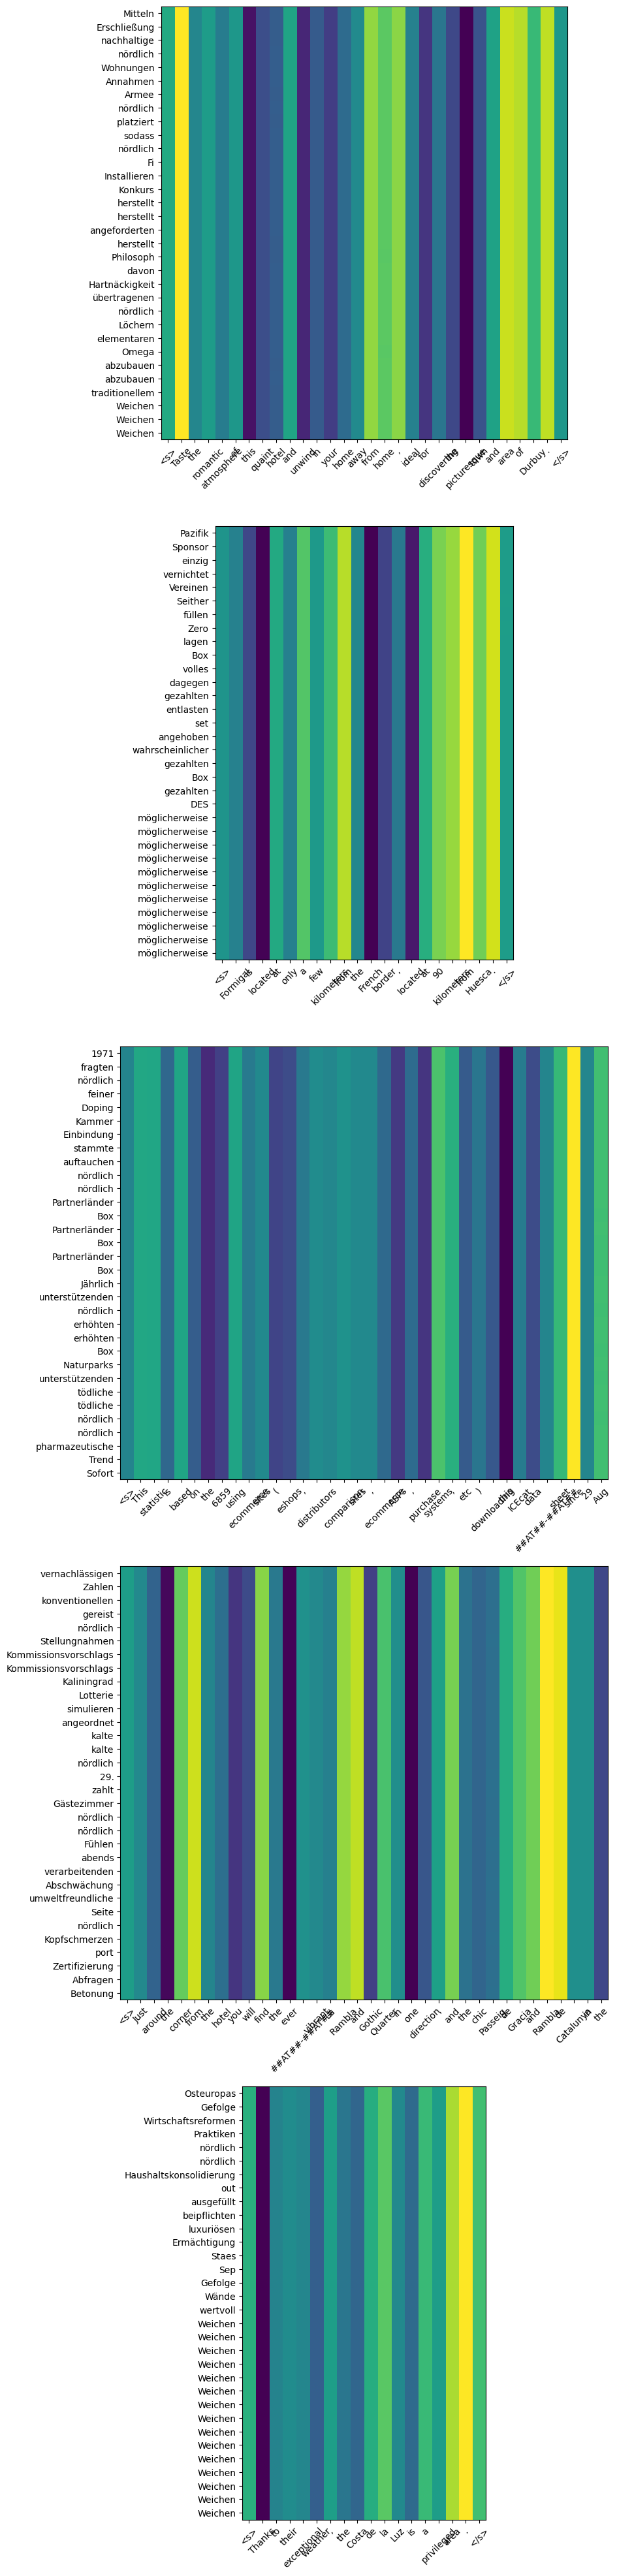

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

_, axes = plt.subplots(5, 1, figsize=(40,50))

attention_results = get_attention_matrix_for_sampled_data(
    attention_visualizer,
    de_lookup_layer,
    (test_en_sentences_padded, test_de_sentences_padded),
    n_samples = 5
)

for ax, result in zip(axes, attention_results):

    ax.imshow(result["attention_weights"])
    x_labels = result["input_words"]
    y_labels = result["predicted_words"]
    ax.set_xticks(np.arange(len(x_labels)))
    ax.set_xticklabels(x_labels, rotation=45)
    ax.set_yticks(np.arange(len(y_labels)))
    ax.set_yticklabels(y_labels, rotation=0)